<h3 align="center">TALLER 2. SIMULADOR PARA ESTUDIAR EL DESEMPEÑO DEL KART ELÉCTRICO</h3>

<div style="text-align: justify"> El presente archivo muestra los requerimientos del taller 2 desarrollados por iteral. Cabe aclarar que los iterales desarrollados en este documento se organizan de una manera distinta a la del enunciado del taller. En cada uno de los se presenta el análisis correspondiente junto con las gráficas necesarias. De esta forma, el contenido del taller 2 acerca del desempeño de un kart eléctrico se divide de la siguiente manera:</div>
<p></p>
<div style="text-align: justify"> <b>1. Parámetros del kart:</b> Para empezar, lo primero a determinar son los parámetros del kart (masa, reducción, inercia, radios, etc.). Estos parámetros se obtuvieron directamente de la documentación de Mariana. De esta forma, con base en estos parámetros se desarollaron los modelos para determinar la velocidad del carro a través del tiempo (tanto en aceleración como en desaceleración). Cabe aclarar que la reducción "ng", a pesar de ser un parámetro constante en esta sección, va a variar hasta 10 veces en la sección 4 para evaluar el desempeño del kart.  </div>
<p></p>
<div style="text-align: justify"> <b>2. Algoritmos computacionales para predecir el desempeño en aceleración del kart:</b> En esta sección se presentan las funciones definidas para resolver la ecuación diferencial "dvelt" mediante la función odeint para el modelo de dinámica longitunidal del vehículo. Como uno de los parámetros de entrada, este modelo utiliza la curva de desempeño del motor sugerida por Clavijo. </div>
<p></p>
<div style="text-align: justify"> <b>3. Desarrollo de un modelo para predecir el desempeño en freno del kart:</b> Con base en los algoritmos anteriores, en esta sección se presenta un modelo similar al anterior pero para el frenado (dfren). En este caso, el torque utilizado ya no entra como una curva sino como un torque constante negativo. </div>
<p></p>
<div style="text-align: justify"> <b>4. Evaluación del desempeño del Kart:</b> En esta sección se presenta la evaluación del desempeño del kart en terminos de velocidad máxima con respecto a dos parámetros del kart: masas y relación de transmisión. </div>
<p></p>
<div style="text-align: justify"> <b>5. Modelo de arranque:</b> Desarrollo de un modelo permita estimar el tiempo y distancia recorrida en un proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero. </div>


In [2]:
import scipy as sp
import numpy as np
import math as m
%pylab inline
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


### 1. Parámetros del Kart para desarrollar los modelos:

<div style="text-align: justify"> Para empezar, se definen todos los parámetros del kart necesarios para desarrollar el modelo. En este caso, los parámetros fueron tomados de la documentación de Mariana y están organizados de la siguiente forma:</div>

In [3]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llreantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # Masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # Peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # Densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525 # Radio piñon(m)
rpla=0.04096 # Radio plato(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)


a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq = 200 # Masa total (kg)

### 2. Algoritmos computacionales para predecir el desempeño en aceleración del kart:

Luego de haber definido los parámetros, en esta sección se muestran los algoritmos computacionales con los cuales se desarrolló el modelo de dinámica longitudinal del kart. Así, se presentan las siguientes tres funciones:

In [15]:
# Función para calcular la fuerza de rodadura
def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0))
    return w*fr*cos(theta) # (N)

In [16]:
# Función para calcular la fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta)

In [17]:
# Función para calcular la fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2

<div style="text-align: justify"> Adicional a estas tres funciones, se define la función torquemotor_curva. En esta, el torque varia de acuerdo a la ecuación de la curva desarrollada por Clavijo. Debido a que existe un límite mecánico y físico en el motor, ni el torque ni la velocidad angular pueden aumentar inifinamente. Por esta razón, para la velocidad máxima se realizó una restricción de 5000 rpm de acuerdo al documento de Clavijo (valor máximo); mientras que para el torque se realizó una restricción de 5.42 Nm de acuerdo al documento de Mariana (Torque Máximo). Así, se presenta la función: </div>

In [18]:
# Función para definir el torque del motor
def torquemotor_curva(omega):
    if omega*60/(2*pi) > 5000:
        omega_mayor = 5000
        P=((-0.00000004564538677*omega_mayor**3)+(0.0001056995459*omega_mayor**2)+(1.53209191*omega_mayor)-1.895523696);
        T=P/(omega_mayor*2*pi/60);
    else:
        omega_mayor = omega*60/(2*pi)
        P=((-0.00000004564538677*omega_mayor**3)+(0.0001056995459*omega_mayor**2)+(1.53209191*omega_mayor)-1.895523696);
        T=P/(omega_mayor*2*pi/60);
    if T > 5.42:
        T = 5.42
    return T

<div style="text-align: justify"> Con base en estos algoritmos, se procede a solucionar el modelo de dinámica longitudinal. Para ello, se creo la función develdt, la cual se utilizará para solucionar la ecuación diferencial. En esta, el torque que entra como una curva que y las condiciones iniciales son cero.</div>

In [19]:
def dveldt(velv,t0):
    xx,vel = velv
    omega_llanta = vel*ng/refc
    omega_motor = omega_llanta
    frod = frodadura_const(vel*3.6)       
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,((torquemotor_curva(omega_motor)*ng*etaf/refc)-frod-farr-fincli)/masa_eq]

Utilizando esta función, se procede a observar el desempeño del kart en aceleración mediante una gráfica que de velocidad y distancia con respecto al tiempo. Así, se presenta la figura 1:

In [20]:
t_in=0  #0
t_fin=200  #200
deltat=0.01
x_0= 0.1
v_0= 0.1
c_ini = [x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

In [21]:
sol = odeint(dveldt, c_ini, t)

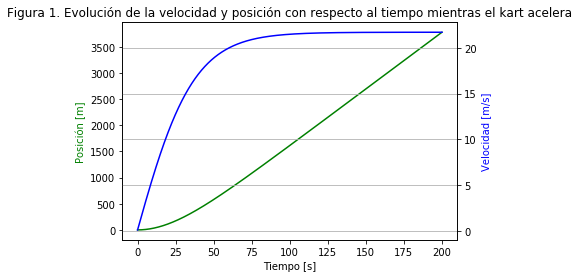

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, sol[:, 0], 'g-', label='Posición(t)')
ax2.plot (t, sol[:, 1], 'b-', label='Velocidad(t)')
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Posición [m]', color='g')
ax2.set_ylabel('Velocidad [m/s]', color='b')
plt.title('Figura 1. Evolución de la velocidad y posición con respecto al tiempo mientras el kart acelera')
plt.grid()
plt.show()
dis_max, vel_max = sol[-1]

## 3. Modelo para predecir el desempeño en freno del kart

<div style="text-align: justify"> Con base en los algoritmos desarrollados en la sección 2, se procede a realizar el modelo para el desempeño del kart en frenado. De esta manera, para resolver la ecuación diferencial se plantea la función dfren. En esta, el torque utilizado es el torque máximo de una de las gráficas de la vuelta de Mariana. Con base en esto, se procede a solucionar la ecuación diferencial. En este caso, las condiciones iniciales son: velocidad máxima en el modelo anterior (vel_max) y distancia inicial aproximada a cero. </div>

In [92]:
def dfren(velv,t0):
    xx,vel = velv
    omega_llanta = vel*ng/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,((-23*ng*etaf/refc)-frod-farr-fincli)/masa_eq]

In [93]:
t_inf=0
t_finf=7
deltatf=0.001
x_0f= 0.1
v_0f = vel_max
c_inif = [x_0f,v_0f]
tf=np.arange(t_inf,t_finf,deltatf)

In [94]:
sol_fren = odeint(dfren, c_inif, tf)

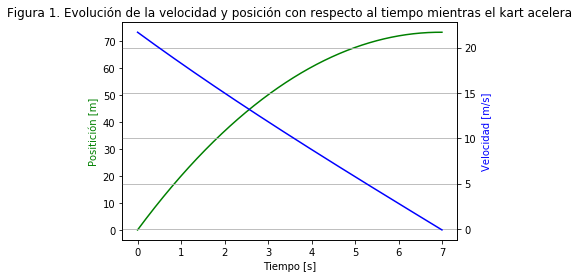

In [95]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(tf, sol_fren[:, 0], 'g-', label='Posición(t)')
ax2.plot (tf, sol_fren[:, 1], 'b-', label='Velocidad(t)')
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Positición [m]', color='g')
ax2.set_ylabel('Velocidad [m/s]', color='b')
plt.title('Figura 1. Evolución de la velocidad y posición con respecto al tiempo mientras el kart acelera')
plt.grid()
plt.show()

### 4. Evaluación de desempeño del kart

Esta sección tiene como objetivo el de evaluar el desempeño del kart cambiando diferentes parámetros. De esta manera, se obtuvieron las gráficas de aceleración y frenado para diferentes relaciones de transmisión y diferentes masas del kart.

In [148]:
def dvel2(velv,t0,rd, masa_k):
    xx,vel = velv
    omega_llanta = vel*rd/refc
    omega_motor = omega_llanta
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,((torquemotor_curva(omega_motor)*rd*etaf/refc)-frod-farr-fincli)/masa_k]

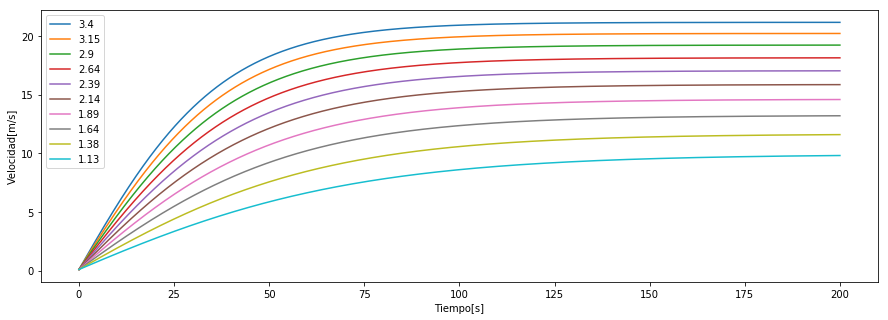

In [156]:
reducciones = [3.40, 3.15, 2.90, 2.64, 2.39, 2.14, 1.89, 1.64, 1.38, 1.13]
sol_red = [()]
for i in range(len(reducciones)):
    sol_r1 = odeint(dvel2, c_ini, t, args=(reducciones[i], masa_eq))
    sol_red.append(sol_r1[:, 1])
    pylab.xlabel("Tiempo[s]")
    pylab.ylabel("Velocidad[m/s]")
    pylab.plot(t, sol_red[i+1], label=f'{reducciones[i]}')
    pylab.grid()
    pylab.legend(loc='upper left')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)

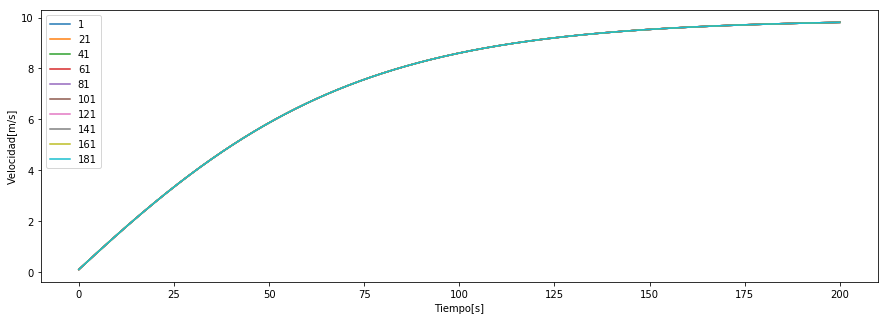

In [174]:
masas_v = np.arange(1,200,20)
sol_mas = [()]
for i in range(len(masas_v)):
    sol_r4 = odeint(dvel2, c_ini, t, args=(ng, masas_v[i]))
    sol_mas.append(sol_r1[:, 1])
    pylab.xlabel("Tiempo[s]")
    pylab.ylabel("Velocidad[m/s]")
    pylab.plot(t, sol_mas[i+1], label=f'{masas_v[i]}')
    pylab.grid()
    pylab.legend(loc='upper left')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)

### 5. Modelo que permita estimar el tiempo y distancia recorrida en un proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero.

Para desarrollar el modelo, se utiliza la funcion darr, la cual funciona de manera similar a los anteriores modelos. En esta función, el kart arranca desde cero y acelera hasta la velocidad máxima, momento en el cual frena hasta detenerse por completo.  

In [180]:
x_inicial = 0.1
v_inicial = 0.1
c_inicial = [x_inicial, v_inicial]
t_inicial = 0
t_final = deltatf
solucion_distancia = []
solucion_velocidad = []
t_corregido = []
for i in range(len(t)-2):
    t_c_ini = t[i]
    t_c_fin = t[i+2]
    t_nuevo = np.arange(t_c_ini, t_c_fin, deltat)
    sol_arr = odeint(dveldt, c_inicial, t_nuevo)
    x_inicial = sol_arr[-1, 0]
    solucion_distancia.append(x_inicial)
    v_inicial = sol_arr[-1, 1]
    solucion_velocidad.append(v_inicial)
    c_inicial = [x_inicial, v_inicial]
    t_i = t[i]
    t_2i = t[i+2]
    t_corregido.append(t[i])
    if (sol_arr[-1,1] - sol_arr[-2,1]) < 1e-4:
        break  
sol_disf = []
sol_velf = [] 
c_n = c_inicial
ultimo_t = []
for i in range(len(t)):
    tfren_ini = t_i+(i*deltat)
    tfren_fin = t_2i+(i*deltat)
    t_nfren = np.arange(tfren_ini, tfren_fin, deltat)
    solfre = odeint(dfren, c_n, t_nfren)
    x_inif = solfre[-1, 0]
    sol_disf.append(x_inif)
    v_inif = solfre[-1, 1]
    sol_velf.append(v_inif)
    c_n = [x_inif, v_inif]
    t_corregido.append(tfren_ini)
    if sol_velf[-1] < 0:
        break
solucion_total_x = solucion_distancia + sol_disf
solucion_total_v = solucion_velocidad + sol_velf


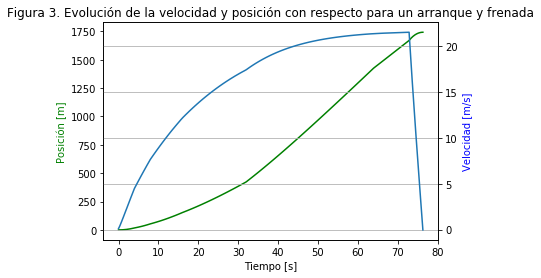

In [181]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t_corregido, solucion_total_x, 'g-', label='Posición(t)')
ax2.plot (t_corregido, solucion_total_v, label='Velocidad(t)')
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Posición [m]', color='g')
ax2.set_ylabel('Velocidad [m/s]', color='b')
plt.title('Figura 3. Evolución de la velocidad y posición con respecto para un arranque y frenada')
plt.grid()
plt.show()
